## <center> Project : Advanced Algorithm and Programming</center>

Author : **Maryline CHEN<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Yves TRAN**

M1 - Informatique, Décision, Données <br/>
University Paris-Dauphine

### Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random as rand
import random as rand
import time
plt.style.use('seaborn')

# Plotting trees 
import ete3
from ete3 import AttrFace, NodeStyle, faces
from IPython.display import Image, display, clear_output, HTML

# Animation 
import matplotlib.animation as animation
from celluloid import Camera

## I. Discrete Unit Disk Cover Problem

In [2]:
class Disk:
    '''
    The Disk is composed of a center point (tuple of coordinates) and a radius.
    The count variable is used for naming each created disks.
    :param x: Coordinates for x-axis
    :param x: Coordinates for y-axis
    :param radius: Length of disk's radius
    :param name: name of the disk (optional)
    '''
    count = 1
    
    def __init__(self, x, y, radius=1, name=None):
        self.center = (x, y)
        self.radius = radius
        self.name = name if name is not None else f'd{Disk.count}'
        Disk.count += 1
        
    def contains(self, point):
        # True if the distance between the center and the given point <= radius
        return ((self.center[0] - point[0]) ** 2 + (self.center[1] - point[1]) ** 2) ** 0.5 <= self.radius
    
    def __repr__(self):
        return self.name


In [3]:
def read_file_dudc(filename, dim=2):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    P = []
    Q = []

    points = False
    disks = False
    for line in lines:
        if line.startswith('\n'): continue
        if line.startswith("%POINTS"):
            points = True
            disks = False
        elif line.startswith('%DISKS'):
            points = False
            disks = True
        elif points:
            arr = line.replace('\n', '').replace('(', '').replace(')', '').split(',')
            P.append((float(arr[0]), float(arr[1])))
        elif disks:
            arr = line.replace('\n', '').replace('(', '').replace(')', '').split(',')
            if dim == 2:
                Q.append(Disk(float(arr[0]), float(arr[1])))
            elif dim == 1:
                interval = (float(arr[0]), float(arr[1]))
                Q.append(interval)
        else:
            print('Please specify %POINTS and %DISKS to distinguish the sets of pairs of integers.')
            return

            
    return P, Q

#### Question 2 : Greedy algorithm for a 1-dimensional plane.

In [4]:
def dudcONE(P,Q):
    '''
    P is a list of points
    Q is a list of intervals 
    '''
    
    def no_cover(p):
        print("We can't cover all the points")
        print("For example : the point", p, "is not covered")
        return [] 
        
   
    def check(p, x1, x2): # check if p if in the interval [a,b]
        if x1 > x2: a,b = x2, x1
        else: a,b = x1, x2
        return (a <= p and p <= b)

    P.sort()  # sort point in ascending order
    Q.sort()  # sort the interval in ascending order
    counter = 0
    I = [] # optimal solution
    j = 0
    
    for p in P : # for each point, we are looking for the interval that contains it
       
        if (len(I) != 0 and check(p[0], I[len(I)-1][0], I[len(I)-1][1])): # an interval in I covers p
            counter += 1
            
        elif j >= len(Q): return no_cover(p) # no interval covers p
        
        else: # we use j to recall the last interval we have seen 
            tmp = counter # use to check if the point p has been covered
            for i in range(j, len(Q)):
                # we add Q[i] iff it is the bigger interval in terms of lower bound that contains p                    
                if check(p[0], Q[i][0], Q[i][1]): 
                    if (i != len(Q)-1 and p[0] < Q[i+1][0]) or (i==len(Q)-1):
                        counter += 1
                        I.append(Q[i])
                        break
                j += 1
            if tmp == counter: # => after iterated over intervals, we didn't cover the point 
                return no_cover(p)
            
    if counter == len(P) : return I
    else : return []

#### Read file

In [5]:
P, Q = read_file_dudc('./instances/dudcONE2.txt', dim=1)
print("P = ", P)
print("Q = ", Q)

print("Interval used : ", dudcONE(P,Q))

P =  [(-0.235, 0.0), (0.93, 0.0), (-2.8, 0.0), (0.14, 0.0), (1.78, 0.0)]
Q =  [(-0.7, 0.2), (-3.0, -2.1), (0.0, 0.9), (1.8, 2.7), (0.93, 1.83), (-0.36, 0.54)]
Interval used :  [(-3.0, -2.1), (-0.36, 0.54), (0.93, 1.83)]


#### Question 5 : Branch-and-Bound algorithm for a 2-dimensional plane.

In [6]:
# Visualizing points and disks
def show(P, Q, figsize=(25, 8), colors=None, split=False):
    """ Plot points and disks
    
    Parameters:
    P (list): List containing points coordinates as tuple
    Q (list): List containing disks)
    figsize (tuple): Size of the graphic
    colors (list) : colors of the disks in Q
    split (boolean): if True, will display two plots, one before finding the solution, 
                    one after the solution has been found.
   """
    def plot_dudc(P, Q, ax, colors=colors):
        # Plot points & disk centers
        points = np.array(P).reshape((len(P), 2))
        ax.scatter(points[:,0], points[:,1])
        centers = np.array([disk.center for disk in Q]).reshape((len(Q), 2))
        ax.scatter(centers[:,0], centers[:,1], color='r', marker='s', s=10)

        # Display points' names
        for i, p in enumerate(P):
            ax.text(p[0]+0.05, p[1]+0.05, f'p{i+1}', color='blue')

        # Plot disks
        for i, disk in enumerate(Q):
            theta = np.linspace(0, 2*np.pi, 100)
            r = np.sqrt(disk.radius)
            x1 = r*np.cos(theta) + disk.center[0]
            x2 = r*np.sin(theta) + disk.center[1]
            ax.text(disk.center[0]-0.9, disk.center[1]+0.3, disk.name, fontsize=13)
            ax.plot(x1, x2, color='grey' if colors is None else colors[i])
            
    ax_i = 1 if split else 0
    fig, ax = plt.subplots(1, ax_i+1, figsize=figsize)
    if split:
        ax[0].axis('equal')
        ax[1].axis('equal')
        plot_dudc(P, Q, ax[0], colors=None)
        plot_dudc(P, Q, ax[1], colors=colors)
    else:
        ax.axis('equal')
        plot_dudc(P, Q, ax, colors=colors)

#### Read file

P =  [(1.5, 2.5), (3.5, 3.5), (4.5, 2.5), (4.5, 3.5), (5.5, 3.5)]
Q =  [d1, d2, d3, d4, d5]


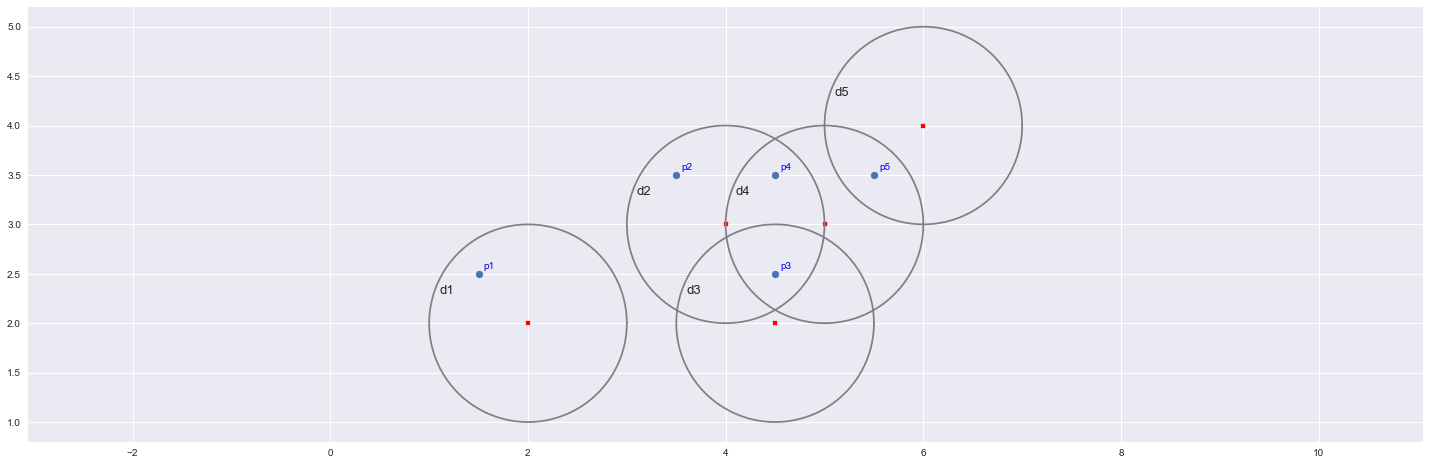

In [7]:
P, Q = read_file_dudc('./instances/dudcTWO.txt', dim=2)
print("P = ", P)
print("Q = ", Q)
show(P, Q)

In [8]:
class BBTree:
    '''
    The BBTree represents a Branch-and-bound tree. 
    :param P: List of tuple which represents a point's coordinates
    :param Q: List of disks
    :param solution: List which will contains the current solution
    :param nb_covered_points: Integer which represents the number of covered points by the current solution
    '''
    
    def __init__(self, P, Q, solution=None, nb_covered_points=0):
        self.solution = solution
        self.nb_covered_points = nb_covered_points
        self.P = P
        self.Q = Q
        self.h_value = self.heuristic()
        self.children = []
        self.closed = False
        self.bound = len(self.solution) if solution is not None else 0
        
    def add_child(self, child):
        self.children.append(child)
    
    def heuristic(self):
        if self.nb_covered_points == 0:
            return 0
        return len(self.solution)/self.nb_covered_points  # Number of covered points
    
    def is_realizable(self, best_score):
        # Check if there is a point that does not belong to any disk
        for point in self.P:
            outlier = True
            for disk in self.Q:
                if disk.contains(point):
                    outlier = False
                    break
            if outlier:
                return False
        # Cannot be realizable if no disk is left nor the current solution size is too high
#         return len(self.Q) > 0 and best_score > len(self.solution)
        return len(self.Q) > 0 and best_score > self.bound
    
    def numPoints(self, points):
        nb = 0
        for p in points:
            if any(d.contains(p) for d in self.Q):
                pass
    
    def __repr__(self):
        return f'({len(self.solution)}, {self.nb_covered_points})'
    
    def split(self):
        """ Splits the current tree into 2 others subtrees. One that contains one more disk is its solution
        and one the does not contains this disk. The chosen disk is the first one in self.Q

        Returns:
        tuple: left subtree (one more disk included), right subtree (no disk included in the solution)
       """
        # Check leaf condition
        if len(self.Q) == 0 or len(self.P) == 0:
            print("Leaf cannot be split")
            return None
        
        # Build disks and points for the left child
        current_disk = self.Q[0]
        remain_pts = [point for point in self.P if not current_disk.contains(point)]
        nb_cov_pts = self.nb_covered_points + len(self.P) - len(remain_pts)
        left_sol = self.solution + [current_disk]
        
        # Disk is added to left node, not to right node
        left = BBTree(remain_pts, self.Q[1:], solution=left_sol, nb_covered_points=nb_cov_pts) 
        right = BBTree(self.P, self.Q[1:], solution=self.solution, nb_covered_points=self.nb_covered_points)  
        return left, right
    
    
def BBTree2ete(bbtree, solution=None):
    """ Converts a branch-and-bound tree to an ete3 tree for visualisation

    Parameters:
    bbtree (BBTree): Branch-and-bound tree to convert
    solution (list): List containing disks of the solution to identify the branch

    Returns:
    tuple: ete3 Tree,
           ete3 TreeStyle
   """
    def custom_layout(node):
        '''Adds the name face to the image at the preferred position'''
        name_face = AttrFace("name")
        faces.add_face_to_node(name_face, node, column=0, position="branch-right")
        
    res_tree = ete3.Tree()
    res_tree.name = repr(bbtree)
    bbtree_to_visit = [bbtree]
    ete_to_visit = [res_tree]

    while len(bbtree_to_visit) > 0:
        current_bbtree = bbtree_to_visit.pop(0)
        current_ete = ete_to_visit.pop(0)

        for bbchild in current_bbtree.children:
            ete_child = ete3.Tree(name=repr(bbchild)+f'\n{bbchild.solution}')
            current_ete.add_child(ete_child)
            if bbchild == solution:
                style = NodeStyle()
                style["bgcolor"] = "Light Green"
                ete_child.set_style(style)
            elif bbchild.closed:
                style = NodeStyle()
                style["bgcolor"] = "#cccccc"
                ete_child.set_style(style)
            
            # Visit child's children if it's not a leaf
            if len(bbchild.children) > 0:
                bbtree_to_visit.append(bbchild)
                ete_to_visit.append(ete_child)
                
    # Tree style parameters
    ts = ete3.TreeStyle()
    ts.scale =  100
    ts.show_leaf_name = False
    ts.layout_fn = custom_layout   
    return res_tree, ts
            
            
def dudcTWO(P, Q, sort=False):
    """ Solves 2-dimesional DUDC instances using Branch-and-bound procedure.
    The bound is the number of covered points. The optimal solution is returned.

    Parameters:
    P (list): List containing points coordinates as tuple
    Q (list): List containing disks)
    sort (boolean): if True, Q is sorted by number of covered points in descending order

    Returns:
    tuple: list containing the minimum disks that cover all points,
           branch-and-bound root, 
           list containing the steps of the algorithm (for visualisation purposes)
   """
    def nbPoints(d, P):
        return len([p for p in P if d.contains(p)])
    
    # Sort Q by the number of points it contains in decreasing order
    if sort:
        Q = sorted(Q, key=lambda d: -nbPoints(d, P))
    logs = []
    root = BBTree(P, Q, solution=[])
    to_visit = [root]
    best_solution_size, best_solution = len(Q)+1, None  # Best solution's size is upper bounded
    tree_to_develop = None
    
    while len(to_visit) != 0:
        # Select the best realizable node
        tree_to_develop = to_visit[0]
        tree_to_develop = min(to_visit, key=lambda x: x.h_value)
        to_visit.remove(tree_to_develop)
        
        # Find children
        children = tree_to_develop.split()
        if children is not None:
            for child in children:
                # Add not realizable node to tree for future visualisation
                tree_to_develop.add_child(child)
                child_is_solution = all(any(disk.contains(pt) for disk in child.solution) for pt in P)
                if child.is_realizable(best_solution_size) and not child_is_solution:
                    to_visit.append(child)
                elif child_is_solution and len(child.solution) < best_solution_size:
                    best_solution_size = len(child.solution)
                    best_solution = child
                    child.closed = True
                    # Remove node where the size of the solution > size of the best solution
                    tmp = []
                    for tree in to_visit:
                        if tree.bound < best_solution_size: tmp.append(tree)
                        else: tree.closed = True
                    to_visit = tmp
                else:
                    child.closed = True
                    
        logs.append(BBTree2ete(root, solution=best_solution))
    return best_solution, root, logs

#### Display the graphical solution 

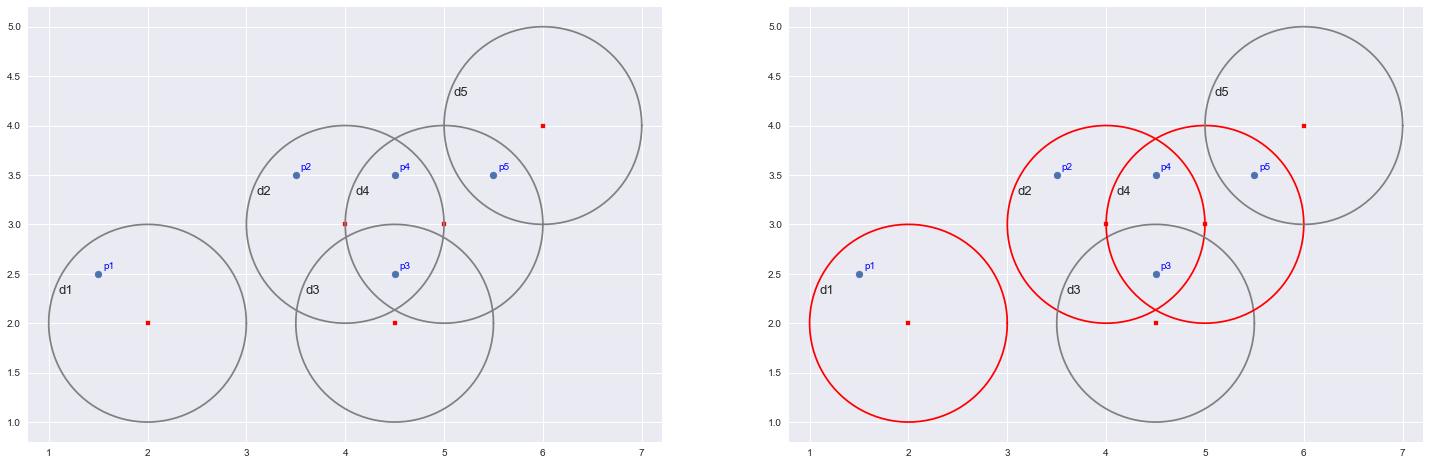

In [9]:
sol_node, root, logs = dudcTWO(P, Q, sort=True)
if sol_node is not None:
    colors = ['red' if disk in sol_node.solution else 'grey' for disk in Q]
    show(P, Q, colors=colors, split=True)

#### Display Branch-and-Bound Tree

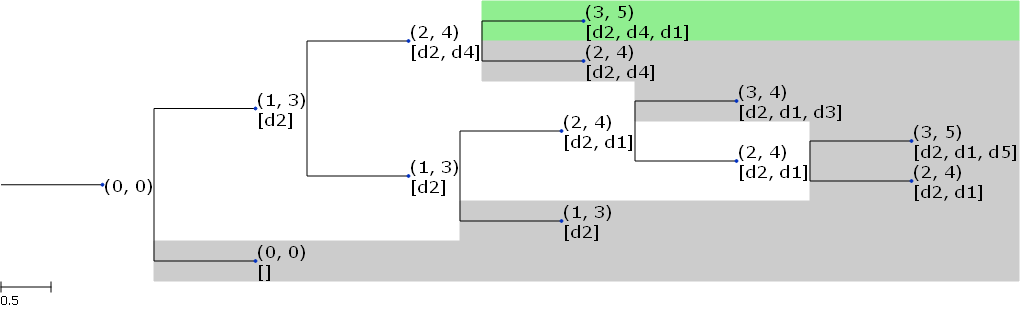

Legend : 
	Green : solution (added from parameters)
	Grey : closed branch


In [10]:
def show_tree(root, sol_node=None):
    """ Displays branch-and-bound tree

    Parameters:
    root (BBTree): Branch-and-bound tree to display
   """
    ete_tree, ts = BBTree2ete(root, sol_node)
    img = ete_tree.render("%%inline", tree_style=ts)
    display(img)
    print("Legend : ")
    print("\tGreen : solution (added from parameters)")
    print("\tGrey : closed branch")
    
show_tree(root, sol_node=sol_node)

#### Animation of each step of the Branch-and-bound algorithm

Legend : 
	Green : solution
	Grey : closed branch


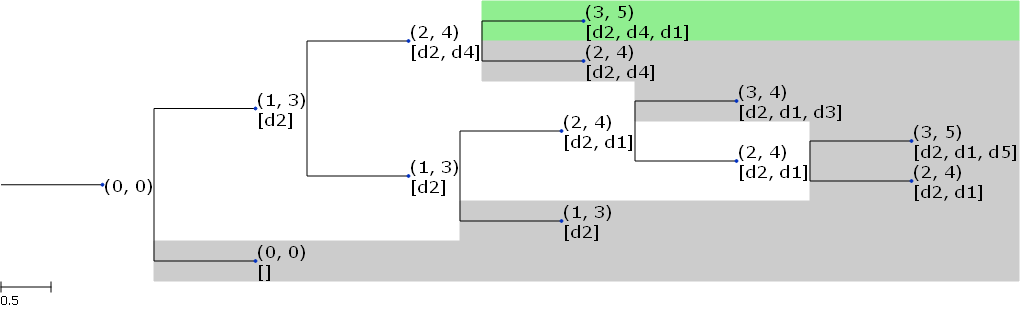

In [11]:
# !!! Execute the code to see the animation !!!
def animate(logs, pause=1):
    """ Displays an animation of the branch-and-bound procedure

    Parameters:
    logs (list): Lists of tuple containing a ete3.Tree and its corresponding ete3TreeStyle each. See output of dudcTWO.
   """
    
    for i in range(len(logs)):
        print("Legend : ")
        print("\tGreen : solution")
        print("\tGrey : closed branch")
        img = logs[i][0].render("%%inline", tree_style=logs[i][1])
        display(img)
        time.sleep(pause)
        clear_output(wait=True) if i < len(logs)-1 else 0
        
animate(logs)

<br/><br/>
## II. Upper Envelope of Some Linear Functions

#### Plotting functions algorithm

In [12]:
def plot_line(x, Y):
    ''' 
    Y : set of functions [(a1,b1),(a2,b2),...,(am,bm)]
    x : a vector where functions will be defined 
    plot_line(x, Y) : plot all functions y in Y for a given vector x
    '''
    for y in Y:
        plt.plot(x,y[0]*x+y[1],label = (str(y[0])+'x+'+str(y[1])))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")


def plot_dashed(x, uE):
    ''' 
    x : a vector where functions will be defined 
    uE : list of coordinates of the upper envelope
    plot_dashed(x, uE) : plot the upper envelope with its breakpoints
    '''
    for item in uE : 
        k = item[0][0]*x+item[0][1]
        i1 = item[1][0] # lower index  
        i2 = item[1][1] # upper index
        t1 = plt.plot(x[i1:i2],k[i1:i2],linewidth=3, dashes=(4, 8), color='red') # plot upperEnvelope
        plt.plot(x[i1],k[i1],'ro', markersize=8) # plot breakpoint
    plt.plot(x[uE[len(uE)-1][1][1]],k[uE[len(uE)-1][1][1]],'ro',markersize=8)
    plt.legend(t1, ['Upper Envelope'])

#### Read file and initialize variables

Y =  [(1.0, 0.0), (-1.0, 0.0), (0.0, 0.5), (-2.1, 6.0), (-4.7, 0.0)]


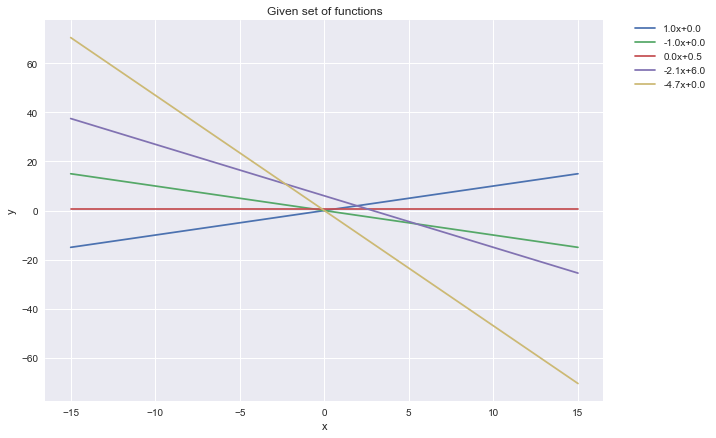

In [13]:
# Read file for upper envelope

def read_file_ue(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    Y = []

    for line in lines:
        if line.startswith('\n'): continue
        else:
            arr = line.replace('\n', '').replace('(', '').replace(')', '').split(',')
            Y.append((float(arr[0]), float(arr[1])))

    return Y
    
Y = read_file_ue('./instances/ue1.txt')
print("Y = ", Y)

# initialize n and x, the vector where each functions in Y will be defined 
n = 100
xk = rand.randint(5,20)
x = np.linspace(-xk, xk, num=n)

# plot the initial set of functions
plt.figure(figsize=(10,7))
plot_line(x,Y)
plt.title("Given set of functions")
plt.show()

#### Question 3 : Divide and Conquer algorithm

In [14]:
# divide Y to single element
def findUE_DC(x, Y):
    if len(Y) == 1: return Y[0]
    else : 
        y1 = Y[:len(Y)//2]
        y2 = Y[len(Y)//2:]
        y1 = findUE_DC(x,y1)
        y2 = findUE_DC(x,y2)
        return conquer(x,y1, y2)


def create(x, f):  
    '''
    f is an upper enveloppe : list of sublist of 2 tuples
    create(x,f) : return a set of point f1 = [f(xi) for i in len(x)]
    '''
    f1 = []
    for item in f:
        k = item[0][0]*x[item[1][0]:item[1][1]+1] + item[0][1]
        f1.extend(k)
    return np.array(f1)



def getFunctionOn(f, start, end):
    '''
    f : a function, it can be only coordinate of the functon or a list of sublist
    start : lower bound index of the interval studied
    end : upper bound index of the interval studied
    getFunctionOn(f, start, end) : return coordinate of f on [start, end] as a list of sublist of two tuples
    '''
    I = []
    # if f is a list => upperEnvelope => not necessarily a linear line
    if len(f) != 0 and type(f[0])==list :
        # for each subfunction of f
        for subFunc in f : 
            lowerIndex = subFunc[1][0]
            upperIndex = subFunc[1][1]
            # current subFunc is above on the interval R = [start, end]
            if (lowerIndex <= start and end <= upperIndex):
                I.append([subFunc[0],(start,end)])
                return I
            # current subFunc is above only on [lowerIndex, end]
            elif (start <= lowerIndex and end <= upperIndex and end >= lowerIndex):
                I.append([subFunc[0],(lowerIndex,end)])
                end = lowerIndex - 1
            # current subFunc is above only on [start, upperIndex]
            elif (lowerIndex <= start and upperIndex <= end and start <= upperIndex):
                I.append([subFunc[0],(start,upperIndex)])
                start = upperIndex + 1
    else : # f is a linear function
        I.append([f,(start,end)])
        return I




def conquer(x, f, g):
    '''
    f, g : functions (it can only be coordinate of function or function as list of sublists)
    x : given vector 
    conquer(x, f, g) : return the upper envelope between f and g over x
    ''' 
    upperE = []
    # calcule [f(xi) for i in range(x)]
    if len(f) != 0 and type(f[0])!=list :
        f1 = f[0]*x + f[1]
    else : f1 = create(x, f)
    # calcule [g(xi) for i in range(x)]
    if len(g) != 0 and type(g[0])!=list :
        g1 = g[0]*x + g[1]
    else : g1 = create(x, g)
    # get the sign of the function f1-g1
    h = np.sign(f1-g1)
    # get index of extremum points
    idx = np.argwhere(np.diff(h)).flatten() 
    # it means : f>g or f<g or f=g
    if len(idx)==0:
        if -1 in h : # g is above f
            upperE.extend(getFunctionOn(g, 0, len(x)-1))
        else :  # f is above g
            upperE.extend(getFunctionOn(f, 0, len(x)-1))
    else:
        # for all segment between breakpoint :
        # if k breakpoints in idx => k+1 segment
        for i in range(len(idx)+1): 
            if i==0 :
                start, end = i, idx[i]
            elif i == len(idx):
                start, end = idx[i-1]+1, len(h)-1
            else :
                start, end = idx[i-1]+1, idx[i]
            if -1 in h[start:end] : # g is bigger than f
                # add coordinate of g over the [start,end]
                upperE.extend(getFunctionOn(g, start, end))
            else : 
                # add coordinate of f over the [start,end]
                upperE.extend(getFunctionOn(f, start, end))
    return upperE

#### Display upper envelope - D&C

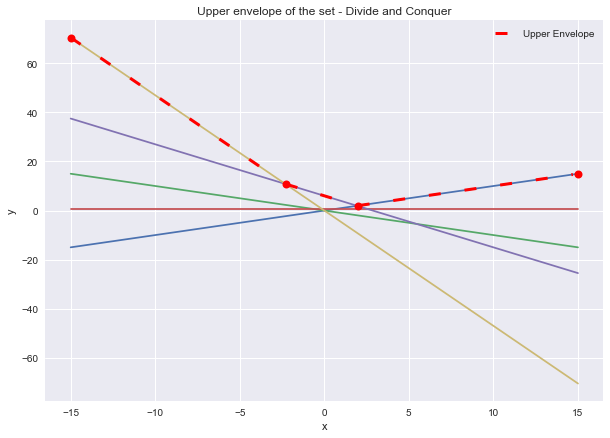

In [15]:
def mainDC(x,Y):
    plot_line(x,Y)
    z = findUE_DC(x,Y)
    plot_dashed(x, z)
    plt.show()

plt.figure(figsize=(10,7))
plt.title("Upper envelope of the set - Divide and Conquer")
mainDC(x,Y)

#### Question 6 : Dynamic Programming algorithm

In [16]:
def findUE_DP(x,Y): 
    memo = []
    for i in range(len(Y)): 
        if len(memo) == 0: 
            memo.append([[Y[i],(0,len(x)-1)]]) 
        else:
            memo.append([])
            memo[i] = conquer(x,Y[i],memo[i-1]) 
    return memo 

#### Display upper envelope - DP

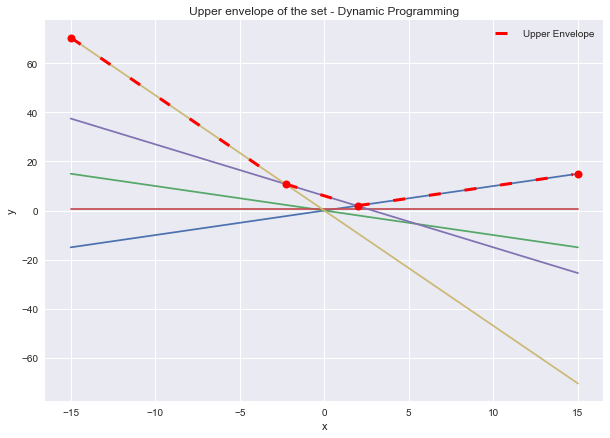

In [17]:
plt.figure(figsize=(10,7))
plot_line(x,Y)
uE = findUE_DP(x,Y)
plot_dashed(x, uE[len(uE)-1])
plt.title("Upper envelope of the set - Dynamic Programming")
plt.show()

#### Animation 

In [18]:
def animation(x, Y, uE):
    Y1 = []
    for y in Y:
        Y1.append(y[0]*x+y[1])
    figsize=(10, 7)
    fig = plt.figure(figsize=figsize)
    camera = Camera(fig)
    visited = []
    j = 0
    for i in range(len(Y1)):
        for y in visited : 
            plt.plot(x, y, color = 'dimgrey', linewidth=1.5)
        if j != 0: plot_dashed(x,uE[j-1])

        plt.plot(x, Y1[i], color = 'cornflowerblue', linewidth=1.5)
        visited.append(Y1[i])
        camera.snap()
        
        for y in visited : 
            plt.plot(x, y, color = 'dimgrey', linewidth=1.5)
        if j != 0: plot_dashed(x,uE[j-1])
    
        camera.snap()
        for y in visited : 
            plt.plot(x, y, color = 'dimgrey', linewidth=1.5)

        plot_dashed(x,uE[j])
        j += 1

       # plt.autoscale()

        camera.snap()
    plt.xlabel("x")
    plt.ylabel("y")
    animation = camera.animate(interval=750)
    return animation

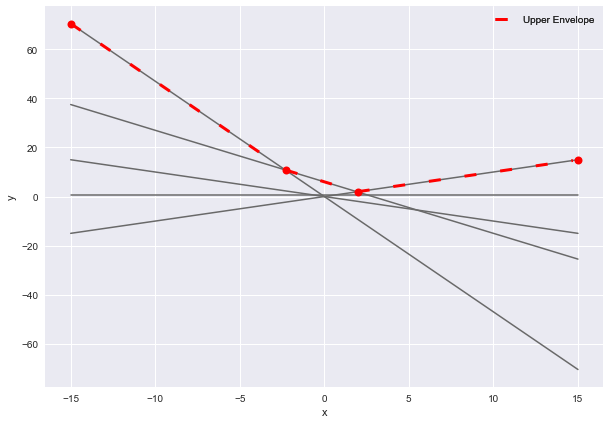

In [19]:
HTML(animation(x, Y, uE).to_jshtml())

# if we want to save the animation :
#animation(x, Y, uE).save('upperEnvelope.mp4')